In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from nltk.tokenize import  word_tokenize

### Data pre-processing and storing into pertinent variables

In [2]:
#### Reading the text file into 'lines' variable

with open("movieReviews1000.txt") as file:
    lines = [line.rstrip() for line in file]

#### Isolating the labels

labels = []
for line in lines:
    l = line[-1]
    labels.append(int(l))

#### Storing only the sentences and removing the labels at the end

sentences = []
for line in lines:
    tmp = str(line[-1])
    line = line.replace(tmp,'')
    sentences.append(line.rstrip())

sentences = np.array(sentences)

for i in range(len(sentences)):
    sentences[i] = (sentences[i].lower())
    

#### Evaluating the unique words in each review

word_set =[]

for line in sentences:
    line = line.replace('-','')
    x = [i.lower() for  i in word_tokenize(line) if i.isalpha()]
    for word in x:
        if word not in word_set:
            word_set.append(word)
    
word_set = set(word_set)

total_documents = len(sentences)

### Implementing TF-IDF for the corpus

In [3]:
#### Creating dictionary to store word count
def count_dict(sentences):
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in sentences:
            if word in sent:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(sentences)


#### Calculating Term Frequency
def termfreq(document, word):
    N = len(document)
    occurance = len([token for token in document if token == word])
    return occurance/N


#### Inverse Document Frequency 
def inverse_doc_freq(word):
    try:
        word_occurance = word_count[word] + 1
    except:
        word_occurance = 1
    return np.log(total_documents/word_occurance)


#### Combining both to create TF-IDF
def tf_idf(sentence):
    tf_idf_vec = np.zeros((len(word_set),))
    for i,word in enumerate(sentence):
        tf = termfreq(sentence,word)
        idf = inverse_doc_freq(word)
         
        value = tf*idf
        tf_idf_vec[i] = value 
    return tf_idf_vec

### Storing the document features 

In [4]:
data = []
for sent in sentences:
    data_point = tf_idf(sent)
    data.append(data_point)

data = np.array(data)

### Function for high dimensional PCA

In [5]:
def PCA(data, d):
    
    X = data
    mean = np.mean(X,axis=0)
    X = X-mean # Obtaining the centered data
    N = 1000
    # cov_mod is the modified covariance matrix given by X*X.T
    cov_mod = X@X.T
    cov_mod = cov_mod/N
    
    eigvals, eigvecs = eigh(cov_mod)
    
    # Reversing order of arrays to represent greatest to smallest values
    eigvals = eigvals[::-1]
    v = eigvecs[::-1]
    v = v[0:d]
    
    # Computing u from v
    
    u = []
    for i, vector in enumerate(v):
        u.append(X.T@(vector/((N*eigvals[i])**0.5)))
        
    u = np.array(u)
    
    # Multiplying sample data with u to get data with reduced dimensionality
    
    y = np.matmul(u, data.T)
    
    return y.T


data = PCA(data, 10)

### Implementing EM Algorithm

In [6]:
#### Defining Gaussian Function
def Gaussian(x, mu, sigma):
    d = len(x)  # Number of entries in the vector
    N = (1/((2*np.pi)**(d/2)))*(np.exp(-0.5*(x-mu)@(np.linalg.inv(sigma))@((x-mu).T)))
    return N


#### Expectation step
def E_step(data, weight, mu, sigma):
    
    n = 1000
    K = 2
    
    num = np.empty([n,K])
    R = np.empty([n,K])
    den = np.zeros(n)
    
    for n, sample in enumerate(data):
        for k in range(K):
            num[n][k] = weight[k]*Gaussian(sample, mu[k], sigma[k])
            den[n] = den[n] + num[n][k]
        
        R[n] = num[n]/den[n]
    
    return R


#### Maximization step
def M_step(R):
    
    R = np.where(np.isnan(R), np.ma.array(R, mask=np.isnan(R)).mean(axis=0), R)  # Making sure that NaNs if created are replaced by mean of their columns
    
    assignment = []  # Array which stores the assigned cluster for all n data points
    for sample in R:
        assignment.append(np.argmax(sample))
        
    N = []  # N stores the count assigned for each Gaussian clusters
    
    for k in range(K):
        N.append(assignment.count(k))
        
    
    # Updating means
    for k in range(K):
        p = 0
        for n in range(len(R)):
            p += R[n][k]*data[n]
        mu[k] = p/N[k]
    
        
    # Updating covariance matrices
    for k in range(K):
        p = np.zeros([10,10])
        for n in range(len(R)):
            X = ((data[n]-mu[k])).reshape(10,1)
            p +=(R[n][k]*X*X.T)
        sigma[k] = p/N[k]
        sigma[k]= np.diag(np.diag(sigma[k]))
    
    
    # Updating weights
    tot = len(data)
    for k in range(K):
        weight[k] = N[k]/tot
        
    
    return assignment, weight, mu, sigma
            
    

### Initializing the parameters using K-Means algorithm

In [7]:
K = 2  # Required number of Gaussians
n = data.shape[0]
d = data.shape[1]
   
# Initializing weights from priors
weight = []
weight.append(labels.count(0)/len(labels))
weight.append(labels.count(1)/len(labels))


# Initializing mean and sigma using K-Means algorithm
kmeans = KMeans(K)
kmeans.fit(data)
identified_clusters = kmeans.fit_predict(data)

mu = np.empty([K,d])
sigma = np.zeros([K,d,d])
for k in range(K):
    tmp = data[np.argwhere(identified_clusters==k)]
    tmp = tmp.reshape(tmp.shape[0],tmp.shape[2])
    mu[k] = tmp.mean(axis=0)
    sigma[k] = tmp.T@tmp
    sigma[k]= np.diag(np.diag(sigma[k]))

#### Storing the data as a Data Frame for ease of plotting

In [8]:
df = pd.DataFrame(data)

### Fitting the model

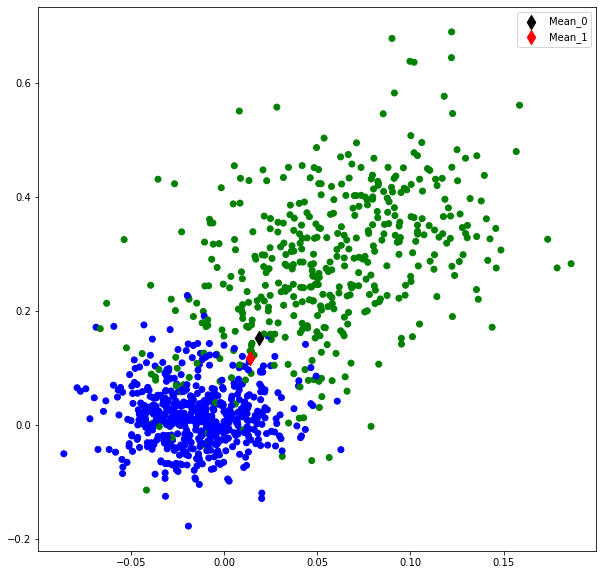

Assigned to 0 (green): 448 
Assigned to 1 (blue): 552


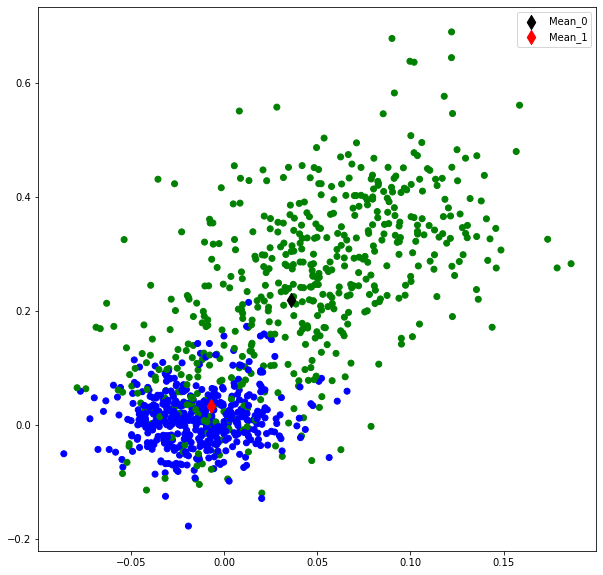

Assigned to 0 (green): 538 
Assigned to 1 (blue): 462


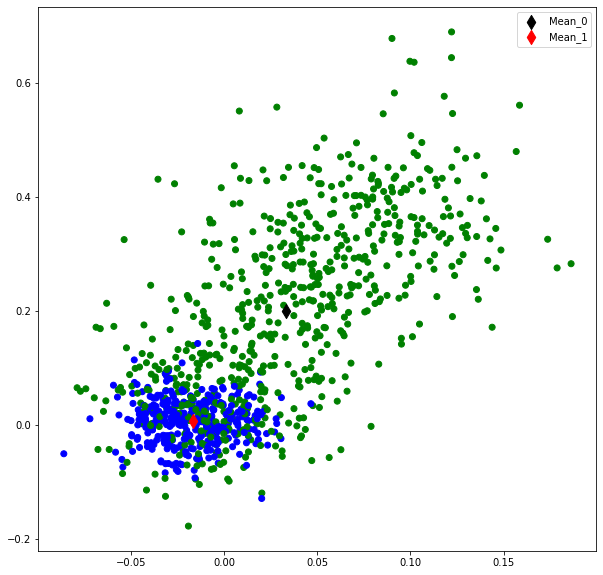

Assigned to 0 (green): 656 
Assigned to 1 (blue): 344


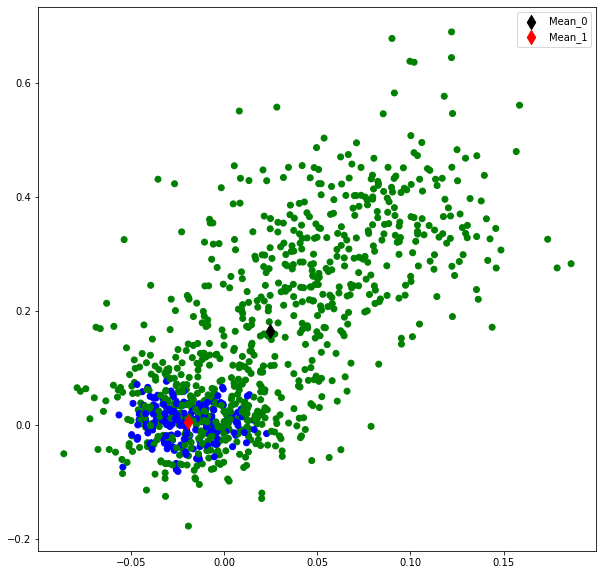

Assigned to 0 (green): 809 
Assigned to 1 (blue): 191


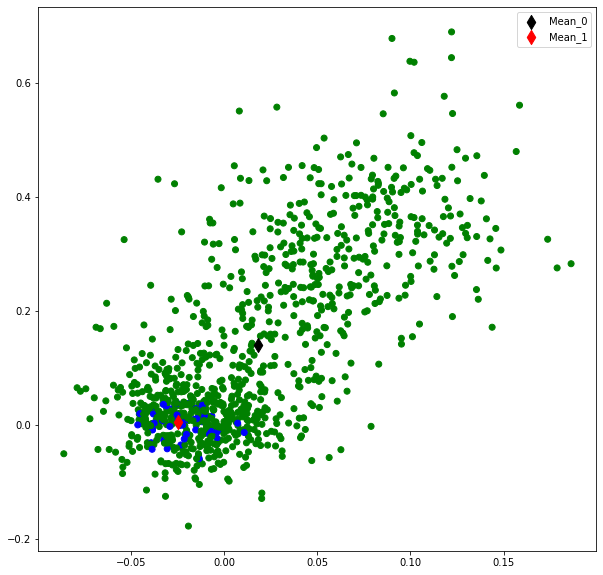

Assigned to 0 (green): 950 
Assigned to 1 (blue): 50


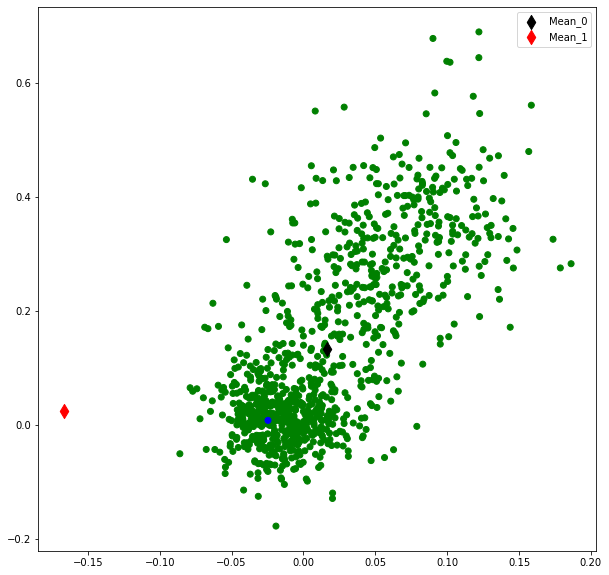

Assigned to 0 (green): 999 
Assigned to 1 (blue): 1


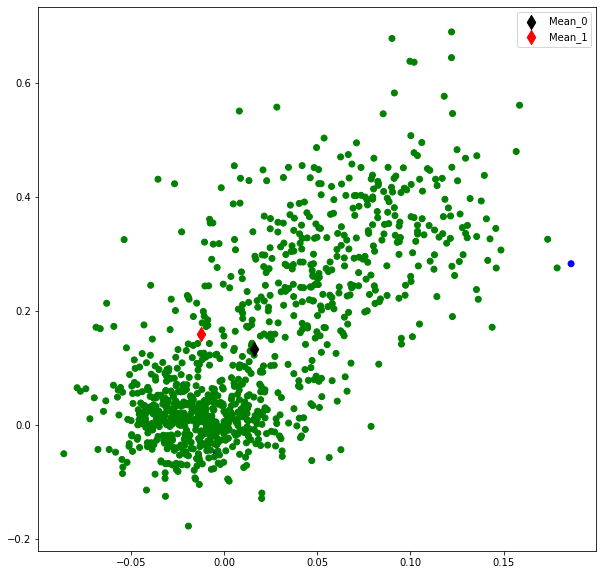

Assigned to 0 (green): 998 
Assigned to 1 (blue): 2


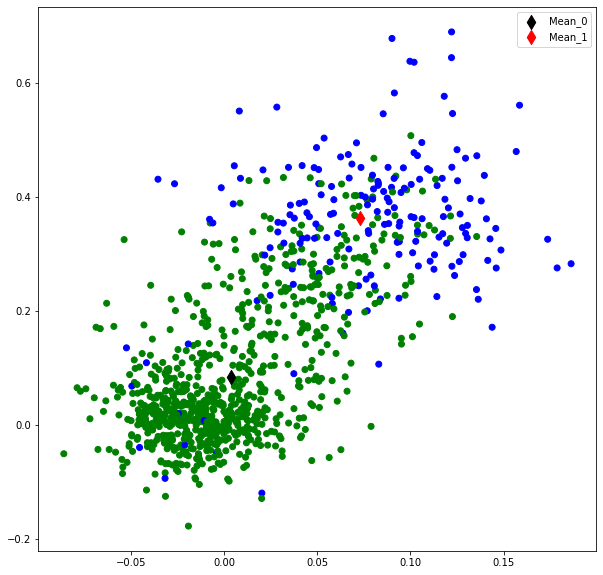

Assigned to 0 (green): 821 
Assigned to 1 (blue): 179


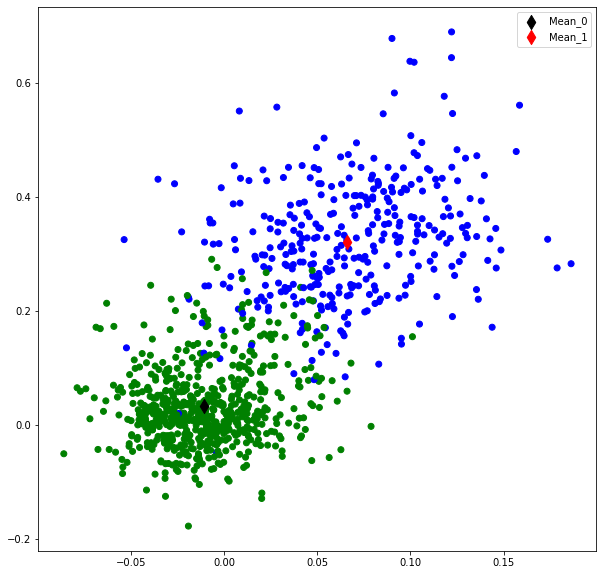

Assigned to 0 (green): 651 
Assigned to 1 (blue): 349


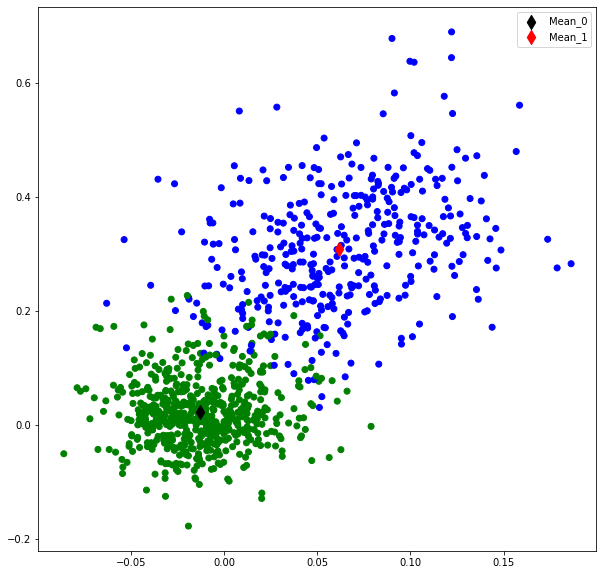

Assigned to 0 (green): 612 
Assigned to 1 (blue): 388


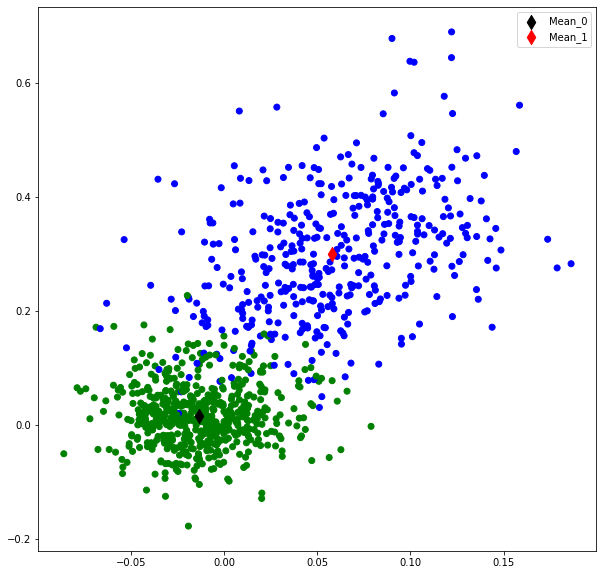

Assigned to 0 (green): 586 
Assigned to 1 (blue): 414


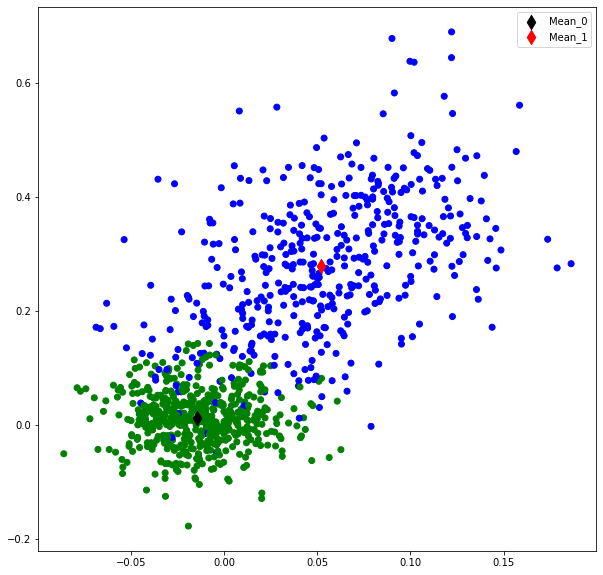

Assigned to 0 (green): 543 
Assigned to 1 (blue): 457


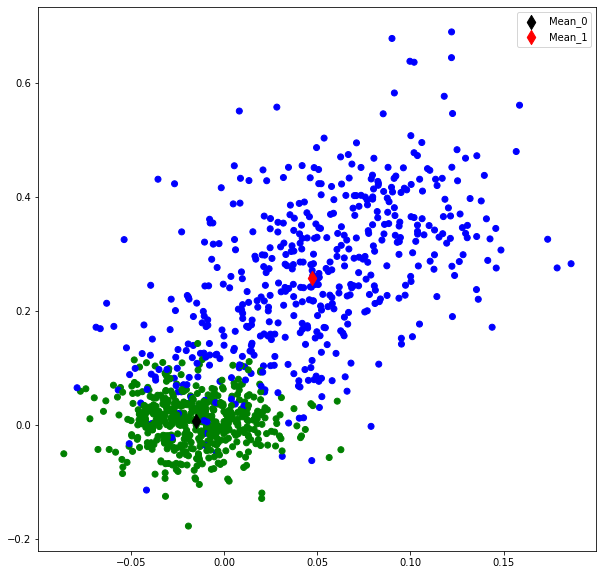

Assigned to 0 (green): 496 
Assigned to 1 (blue): 504


In [9]:
for _ in range(13):  # 8 iterations were found to produce the desired classification 
    R = E_step(data, weight, mu, sigma)
    assignment, weight, mu, sigma = M_step(R)
    

    plt.figure(figsize=[10,10])
    
    map_label = {0 : 'green', 1 : 'blue'}

    label_color = [map_label[a] for a in assignment]      # Creating mapping to assign colours to data points
    
    
    plt.scatter(df[0],df[1], c=label_color)
        
    plt.scatter(mu[0][0], mu[0][1], c ='black', marker='d', s = 100, label='Mean_0')
    plt.scatter(mu[1][0], mu[1][1], c ='red', marker='d', s = 100, label='Mean_1')
    plt.legend()
    plt.show()
    print("Assigned to 0 (green):",assignment.count(0), "\nAssigned to 1 (blue):", assignment.count(1))